# Project #2
### For this project we will be analysing the priors and COVID-19 evolution in Chile, for this, we will make a model using PyMC

In [1]:
import pandas as pd
import pymc3 as pm
import pystan
import seaborn as sns
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import statsmodels.api as sm

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## We will be using the data from MinCiencia

In [2]:
# Datos-COVID19/output/producto49/Positividad_Diaria_Media_T.csv
# positivity is casos pcr/pcr
meandpos = pd.read_csv('https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto49/Positividad_Diaria_Media_T.csv')

meandpos['Fecha'] = pd.to_datetime(meandpos['Fecha'], format = '%Y-%m-%d')
meandpos = meandpos[meandpos['Fecha']>'2022-01']
meandpos['pcr'] = meandpos['pcr'].astype(int)
meandpos['casos pcr'] = meandpos['casos pcr'].astype(int)
meandpos['casos ag'] = meandpos['casos ag'].astype(int)

meandpos.head()

,Fecha,pcr,casos pcr,casos ag,positividad pcr,mediamovil_positividad_pcr
648,2022-01-02,54709,1723,198,0.0315,0.0270
649,2022-01-03,23586,870,135,0.0369,0.0286
650,2022-01-04,21305,810,248,0.0380,0.0300
651,2022-01-05,43127,1380,478,0.0320,0.0314
652,2022-01-06,64928,2493,641,0.0384,0.0334


In [3]:
x = meandpos["Fecha"]
y = meandpos["casos pcr"]
print(len(x))

180


<AxesSubplot:xlabel='casos pcr', ylabel='Count'>

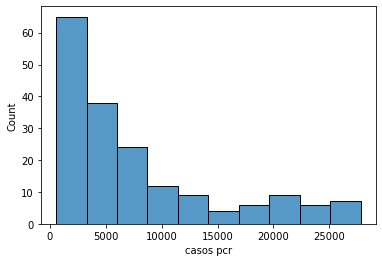

In [4]:
sns.histplot(y)

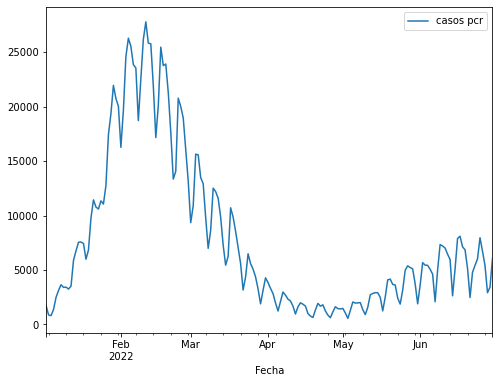

In [5]:
ax = meandpos.plot("Fecha", "casos pcr", figsize = (8,6))

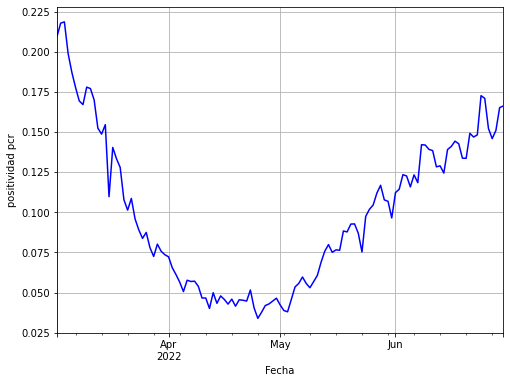

In [30]:
m = meandpos[meandpos['Fecha']>'2022-03-01']
ax = m.iloc[:].plot('Fecha', 'positividad pcr', legend=False, figsize=(8,6),c="blue")
ax.set_ylabel('positividad pcr')
plt.grid()

In [22]:
n = (m['Fecha'] - m['Fecha'].iat[0]).dt.days.values
tasa = m['positividad pcr'].values
df = pd.DataFrame({'Fecha': n, 'Positividad': tasa})
df.head()

,Fecha,Positividad
0,0,0.2096
1,1,0.2180
2,2,0.2188
3,3,0.1991
4,4,0.1874


## Model

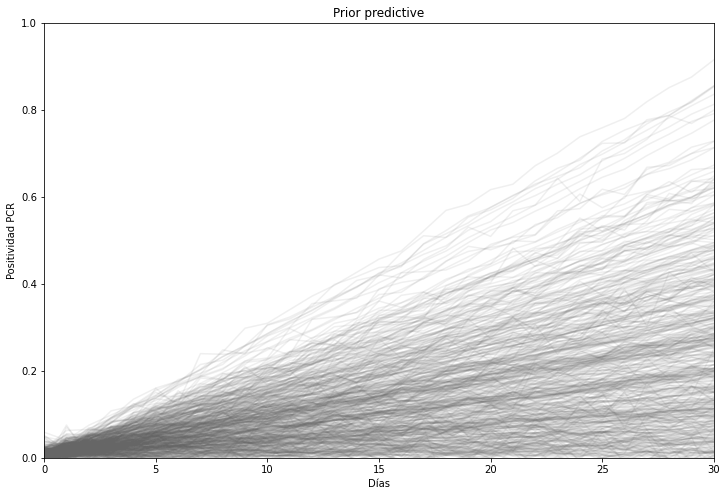

In [61]:
with pm.Model(check_bounds = False) as model:
    alpha = pm.HalfNormal('alpha', 0.01)
    beta = pm.HalfNormal('beta', 0.01)
    eps = pm.HalfNormal('eps', 0.01)
    trend = pm.Deterministic('trend', alpha + beta*n)

    pm.Normal('obs', mu = trend, sigma = eps, observed = tasa)

    prior = pm.sample_prior_predictive()


fig, ax = plt.subplots(figsize=(12,8))
ax.plot(prior["obs"].T,color=".4",alpha=.1)
ax.set(ylim=(0,1),
       xlim=(0,30),
       title = "Prior predictive",
       xlabel="Días",
       ylabel="Positividad PCR");

In [34]:
sampler = {'chains': 4, 'cores': 4, 'return_inferencedata': True}

with model:
    end_model = pm.sample (**sampler, tune=2500)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, beta, alpha]
INFO:pymc3:NUTS: [eps, beta, alpha]


Sampling 4 chains for 2_500 tune and 1_000 draw iterations (10_000 + 4_000 draws total) took 38 seconds.
INFO:pymc3:Sampling 4 chains for 2_500 tune and 1_000 draw iterations (10_000 + 4_000 draws total) took 38 seconds.


## Finally we run Arviz and see if the model fits correctly

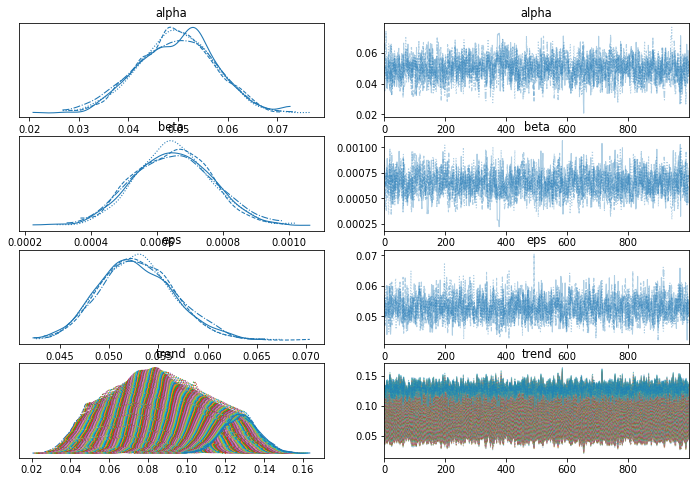

In [35]:
az.plot_trace(end_model);

In [26]:
az.summary(end_model)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.054,0.007,0.042,0.069,0.0,0.0,1714.0,1724.0,1.0
beta,0.001,0.000,0.000,0.001,0.0,0.0,1686.0,1220.0,1.0
eps,0.048,0.003,0.043,0.053,0.0,0.0,1945.0,2138.0,1.0
trend[0],0.054,0.007,0.042,0.069,0.0,0.0,1714.0,1724.0,1.0
trend[1],0.055,0.007,0.043,0.069,0.0,0.0,1719.0,1740.0,1.0
...,...,...,...,...,...,...,...,...,...
trend[116],0.123,0.008,0.108,0.138,0.0,0.0,2326.0,1907.0,1.0
trend[117],0.124,0.008,0.108,0.139,0.0,0.0,2312.0,1907.0,1.0
trend[118],0.124,0.008,0.109,0.140,0.0,0.0,2299.0,1897.0,1.0
trend[119],0.125,0.008,0.109,0.140,0.0,0.0,2287.0,1905.0,1.0
